# Image Deduplication

Image deduplication is the process of finding exact or near-exact duplicates within a collection of images. For example:

![Example](image_dedup.png)

In particular, note that the middle image in the bottom row is not identical to the other two images, despite being a "duplicate". This is where the difficulty lies - matching pure duplicates is a simple process, but matching images which are similar in the presence of changes in zoom, lighting, and noise is a much more challenging problem.


## Key components

In this section, we go over some key technologies (models, modules, scripts, etc...) used to successfully implement an image deduplication algorithm.


### Encoder-based embedding model


A generic embedding model turns images into dense vectors; an encoder-based embedding model outputs dense vectors which encode scale-invariant edges and corners within the input image as opposed to pure semantic information. For example, while two images of different dogs may result in two very similar encodings when using traditional object recognition embedding models, the output embeddings would be very different when using encoding-based embedding models. This [blog post](https://towardsdatascience.com/contrastive-loss-explaned-159f2d4a87ec) is a great resource for understanding contrastive loss.

To accomplish this, these encoder models shouldn't be trained on traditional image recognition/localization datasets such as CIFAR or ImageNet; instead, a siamese network trained with contrastive or triplet loss must be used. Among all these encoder-based embedding models, `resnet` is a widely applied one. In this tutorial, we take `resnet50` as an example to show Towhee's capability of comparing similar images in a few lines of code with image-processing operators and pre-built embedding models:

target,image,path,emb,target_emb
,,Lenna.png,"[0.88811624, 0.053701527, 0.0, ...] shape=(2048,)","[0.88811624, 0.053701527, 0.0, ...] shape=(2048,)"
,,logo.png,"[0.27532643, 0.019467035, 0.0, ...] shape=(2048,)","[0.88811624, 0.053701527, 0.0, ...] shape=(2048,)"

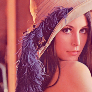
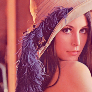
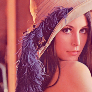
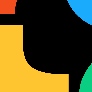

In [3]:
from towhee import pipe, ops
from towhee.datacollection import DataCollection

emb_pipe = (
    pipe.input('target', 'path')
        .flat_map('path', 'path', lambda x: x)
        .map('target', 'target', ops.image_decode.cv2('rgb'))
        .map('path', 'image', ops.image_decode.cv2('rgb'))
        .map('target', 'target_emb', ops.image_embedding.timm(model_name='resnet50'))
        .map('image', 'emb', ops.image_embedding.timm(model_name='resnet50'))
)

emb_res = emb_pipe.output('target', 'image', 'path', 'emb', 'target_emb')('Lenna.png', ['Lenna.png', 'logo.png'])

DataCollection(emb_res).show()

A `resnet50` model is trained to output extremely close embeddings for two "similar" input images, i.e. zero, one, or many of the following transformations:

1. Color conversion, e.g. changes in lighting/contrast
2. Up to 150% zoom plus a random crop
3. Additive salt-and-pepper (Gaussian) noise

These transformations render the model invariant to changes in zoom, lighting, and noise.

### Similarity metric


Now we have the embedding of the images stored in dc, but the embeddings themselves are useless without a similarity metric. Here, we check if the L2 norm of the difference vector between the query and target images is within a certain threshold. If so, then the images are considered duplicates.

Towhee also support runnig a self-defined function as operator with `runas_op`, so users are allowed to run any metrics effortless once they define the metric function:

target,image,is_similar
,,True
,,False

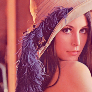
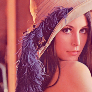
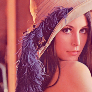
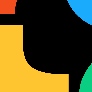

In [5]:
import numpy as np

thresh = 0.01
detect_res = (
    emb_pipe.map(('emb', 'target_emb'), 'is_similar', lambda x, y: np.linalg.norm(x - y) < thresh)
        .output('target', 'image', 'is_similar')
)

res = detect_res('Lenna.png', ['Lenna.png', 'logo.png'])
DataCollection(res).show()

This is an empirically determined threshold based on experiments run on a fully trained model.

## Putting it all together

Putting it all together, we can check if two images are duplicate with the following code snippet:

target,image,is_similar
,,True
,,False

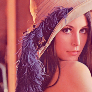
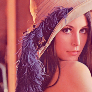
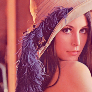
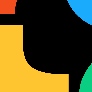

In [7]:
import numpy as np
from towhee import pipe, ops
from towhee.datacollection import DataCollection

thresh = 0.01
p = (
    pipe.input('target', 'path')
        .flat_map('path', 'path', lambda x: x)
        .map('target', 'target', ops.image_decode.cv2('rgb'))
        .map('path', 'image', ops.image_decode.cv2('rgb'))
        .map('target', 'target_emb', ops.image_embedding.timm(model_name='resnet50'))
        .map('image', 'emb', ops.image_embedding.timm(model_name='resnet50'))
        .map(('emb', 'target_emb'), 'is_similar', lambda x, y: np.linalg.norm(x - y) < thresh)
        .output('target', 'image', 'is_similar')
)

res = p('Lenna.png', ['Lenna.png', 'logo.png'])
DataCollection(res).show()